# ST451 Project: Why We Use

Structure

1. Classification
    1. Logistic regression (w/ penalties)
    2. Bayesian logistic regression
    3. GP
    4. Summary plots

2. Regression
    1. Linear regression (w/ penalties)
    2. Bayesian linear regression
    3. GP
    4. Summary plots

In [34]:
# Load dependencies
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
from sklearn.gaussian_process import (GaussianProcessClassifier,
                                      GaussianProcessRegressor)
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.linear_model import (ElasticNet, Lasso, LinearRegression,
                                  LogisticRegression, Ridge)
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, r2_score, roc_auc_score,
                             roc_curve) 
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.inspection import permutation_importance
from ucimlrepo import fetch_ucirepo

In [35]:
# Preprocessing
drugs = fetch_ucirepo(id = 373)

x = drugs.data.features
y = drugs.data.targets

# print(drugs.metadata)
# print(drugs.variables)

# Select features
features = ['age', 'gender', 'education', 'nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impuslive', 'ss']
X = x[features].values

# For classification: make cocaine user dummy (irregular users vs. more regular users)
y_coke_dummy = pd.get_dummies(y['coke'] > 'CL1', drop_first=True).values.ravel()
# y_coke_dummy = pd.get_dummies(y['coke'] != 'CL0', drop_first=True).values.ravel() # strict user vs non-user

# For regression: make cocaine user score
coke_map = {f'CL{i}': i for i in range(7)}
y_coke_score = y['coke'].map(coke_map).values

# Split data for classification task
X_train, X_test, y_train, y_test = train_test_split(X, y_coke_dummy, test_size=0.25, random_state=42)
# For regression task
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_coke_score, test_size=0.25, random_state=42)

## I. Classification

### 1. Logistic regression


Tuning Logistic Regression (no penalty)...
Best parameters: {}
Accuracy: 0.6907
ROC AUC: 0.7238
Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.82      0.77       303
        True       0.59      0.47      0.52       169

    accuracy                           0.69       472
   macro avg       0.66      0.64      0.65       472
weighted avg       0.68      0.69      0.68       472


Tuning Logistic Regression (L1)...
Best parameters: {'C': np.float64(0.3593813663804626)}
Accuracy: 0.6864
ROC AUC: 0.7232
Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.82      0.77       303
        True       0.58      0.46      0.51       169

    accuracy                           0.69       472
   macro avg       0.65      0.64      0.64       472
weighted avg       0.68      0.69      0.68       472


Tuning Logistic Regression (L2)...
Best parameters: {'C': np.float64(0.0464158

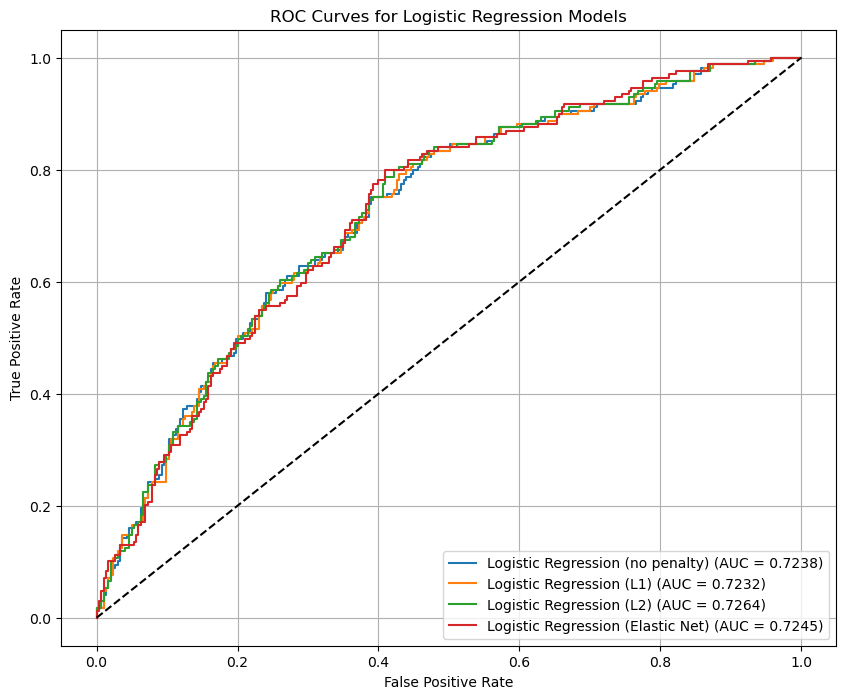

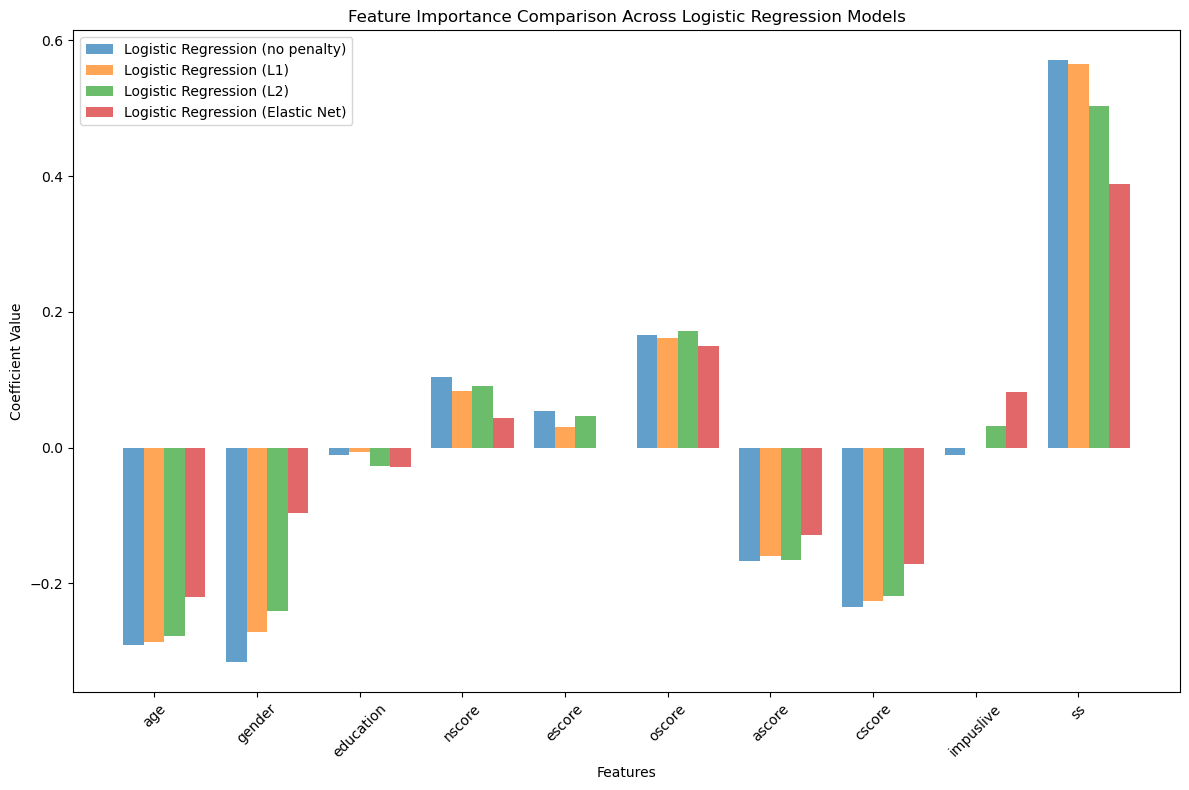


Model Performance Comparison:
                               Model  Accuracy       AUC
2           Logistic Regression (L2)  0.692797  0.726424
3  Logistic Regression (Elastic Net)  0.680085  0.724549
0   Logistic Regression (no penalty)  0.690678  0.723846
1           Logistic Regression (L1)  0.686441  0.723182


In [36]:
# 1. Logistic regression (with different penalty terms)

# Create a dictionary to store results
results = {}

# Define the models with different regularization
log_reg_models = {
    'Logistic Regression (no penalty)': LogisticRegression(penalty=None, random_state=42, max_iter=5000),
    'Logistic Regression (L1)': LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=5000),
    'Logistic Regression (L2)': LogisticRegression(penalty='l2', random_state=42, max_iter=5000),
    'Logistic Regression (Elastic Net)': LogisticRegression(penalty='elasticnet', solver='saga', random_state=42, max_iter=5000)
}

# Parameters for grid search
param_grids = {
    'Logistic Regression (no penalty)': {},
    'Logistic Regression (L1)': {'C': np.logspace(-4, 4, 10)},
    'Logistic Regression (L2)': {'C': np.logspace(-4, 4, 10)},
    'Logistic Regression (Elastic Net)': {
        'C': np.logspace(-4, 4, 5),
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
}

# Fit models and evaluate
plt.figure(figsize=(10, 8))
for name, model in log_reg_models.items():
    print(f"\nTuning {name}...")
    
    # Grid search for hyperparameter tuning
    grid_search = GridSearchCV(
        model, 
        param_grids[name], 
        cv=5, 
        scoring='roc_auc',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'auc': auc_score,
        'model': best_model
    }
    
    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {auc_score:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")

# Finalize ROC curve plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Compare coefficients across models
plt.figure(figsize=(12, 8))
bar_width = 0.2
index = np.arange(len(features))

for i, (name, result) in enumerate(results.items()):
    if hasattr(result['model'], 'coef_'):
        coeffs = result['model'].coef_[0]
        plt.bar(index + i*bar_width, coeffs, bar_width, label=name, alpha=0.7)

plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Importance Comparison Across Logistic Regression Models')
plt.xticks(index + bar_width, features, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Create a results comparison table
results_table = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results],
    'AUC': [results[name]['auc'] for name in results]
})

# Sort by AUC score
results_table = results_table.sort_values('AUC', ascending=False)
print("\nModel Performance Comparison:")
print(results_table)

### 2. Bayesian logistic regression

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


Prior sigma = 0.1: Accuracy = 0.6737, AUC = 0.7370


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


Prior sigma = 0.25: Accuracy = 0.6801, AUC = 0.7371


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


Prior sigma = 0.5: Accuracy = 0.6801, AUC = 0.7361


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


Prior sigma = 0.75: Accuracy = 0.6801, AUC = 0.7360


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


Prior sigma = 1: Accuracy = 0.6794, AUC = 0.7360


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


Prior sigma = 3: Accuracy = 0.6801, AUC = 0.7358


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


Prior sigma = 5: Accuracy = 0.6801, AUC = 0.7358


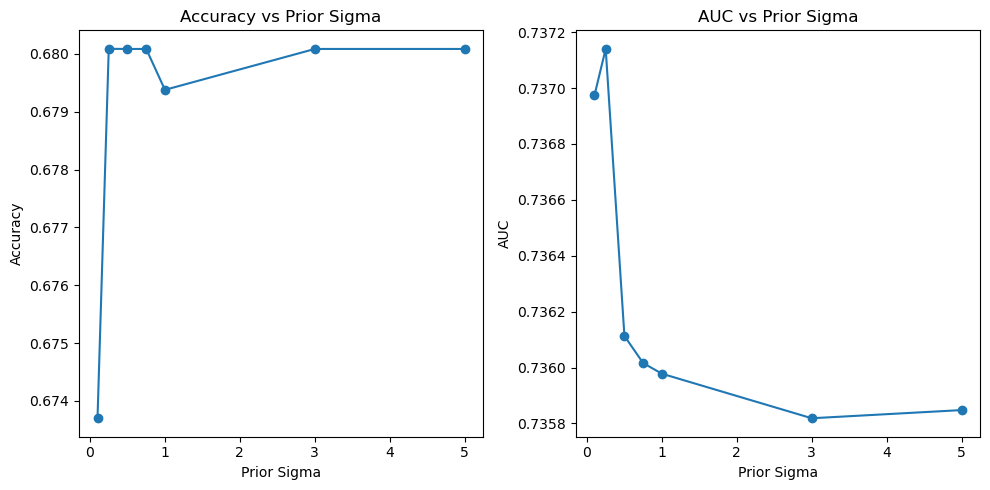


Best prior sigma based on cross-validation: 0.25


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Bayesian Logistic Regression - Test Accuracy: 0.6907, AUC: 0.7259


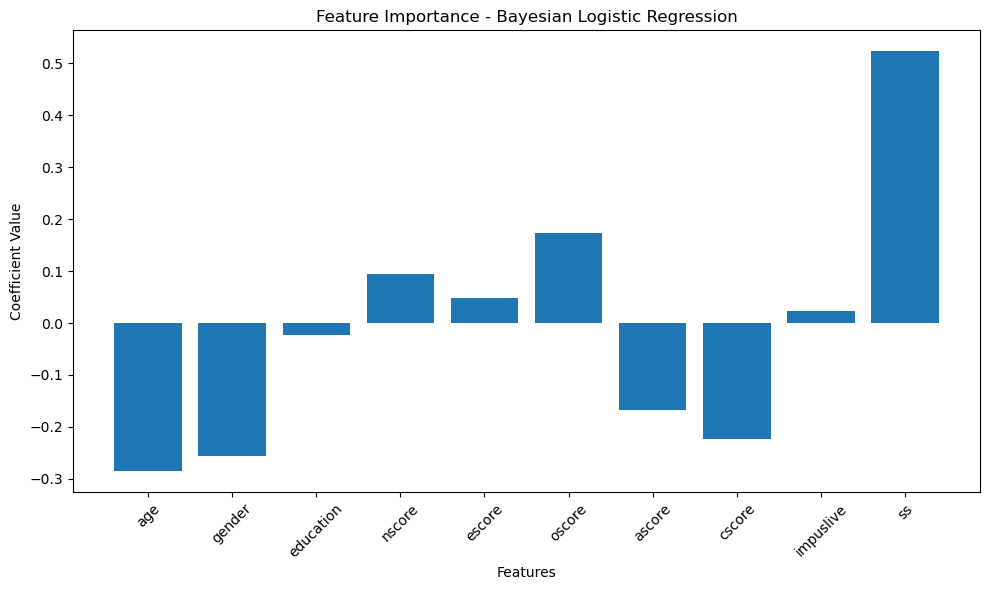


Model Performance Comparison:
                               Model  Accuracy       AUC
2           Logistic Regression (L2)  0.692797  0.726424
4       Bayesian Logistic Regression  0.690678  0.725858
3  Logistic Regression (Elastic Net)  0.680085  0.724549
0   Logistic Regression (no penalty)  0.690678  0.723846
1           Logistic Regression (L1)  0.686441  0.723182


In [37]:
# 2. Bayesian logistic regression

# To run on Silicon Mac: force PyTensor to use Apple's system compiler
pytensor.config.cxx = "/usr/bin/clang++"
# Suppress some warnings to make output more readable
warnings.filterwarnings("ignore", category=UserWarning)


# Evaluate a range of priors for Bayesian logistic regression using cross-validation

# Define different prior standard deviations to test
prior_sigmas = [0.1, 0.25, 0.5, 0.75, 1, 3, 5]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []

# Perform cross-validation for each prior configuration
for sigma in prior_sigmas:
    fold_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        # Split data for this fold
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        # Create and sample from model with current sigma
        with pm.Model() as fold_model:
            # Priors with current sigma
            alpha = pm.Normal("alpha", mu=0, sigma=3)
            beta = pm.Normal("beta", mu=0, sigma=sigma, shape=X_fold_train.shape[1])
            
            # Expected value of outcome
            mu = alpha + pm.math.dot(X_fold_train, beta)
            # Likelihood of observations
            y_obs = pm.Bernoulli("y_obs", logit_p=mu, observed=y_fold_train)
            
            # Sample from posterior (using a smaller number for cross-validation)
            trace = pm.sample(500, tune=500, random_seed=42, return_inferencedata=True)
            
            # Make predictions on validation set
            alpha_samples = trace.posterior.alpha.values.flatten()
            beta_samples = trace.posterior.beta.values.reshape(-1, X_fold_train.shape[1])
            
            # Calculate predictions
            logit_p = alpha_samples[:, None] + np.dot(beta_samples, X_fold_val.T)
            probs = 1 / (1 + np.exp(-logit_p))
            y_pred_proba = probs.mean(axis=0)
            y_pred = (y_pred_proba > 0.5).astype(int)
            
            # Evaluate performance
            accuracy = (y_pred == y_fold_val).mean()
            auc = roc_auc_score(y_fold_val, y_pred_proba)
            fold_scores.append((accuracy, auc))
    
    # Average scores across folds
    mean_accuracy = np.mean([score[0] for score in fold_scores])
    mean_auc = np.mean([score[1] for score in fold_scores])
    cv_results.append((sigma, mean_accuracy, mean_auc))
    print(f"Prior sigma = {sigma}: Accuracy = {mean_accuracy:.4f}, AUC = {mean_auc:.4f}")

# Plot the results
plt.figure(figsize=(10, 5))
sigmas, accuracies, aucs = zip(*cv_results)

plt.subplot(1, 2, 1)
plt.plot(sigmas, accuracies, 'o-')
plt.xlabel('Prior Sigma')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Prior Sigma')

plt.subplot(1, 2, 2)
plt.plot(sigmas, aucs, 'o-')
plt.xlabel('Prior Sigma')
plt.ylabel('AUC')
plt.title('AUC vs Prior Sigma')

plt.tight_layout()
plt.show()

# Choose the best prior sigma based on AUC
best_sigma_idx = np.argmax([res[2] for res in cv_results])
best_sigma = cv_results[best_sigma_idx][0]
print(f"\nBest prior sigma based on cross-validation: {best_sigma}")

# Train the model with the best sigma on the full training set and evaluate on test set
with pm.Model() as final_model:
    # Priors with best sigma
    alpha = pm.Normal("alpha", mu=0, sigma=3)
    beta = pm.Normal("beta", mu=0, sigma=best_sigma, shape=X_train.shape[1])
    
    # Expected value of outcome
    mu = alpha + pm.math.dot(X_train, beta)
    # Likelihood of observations
    y_obs = pm.Bernoulli("y_obs", logit_p=mu, observed=y_train)
    
    # Sample from posterior
    trace = pm.sample(1000, tune=1000, random_seed=42, return_inferencedata=True)
    
    # Make predictions on test set
    alpha_samples = trace.posterior.alpha.values.flatten()
    beta_samples = trace.posterior.beta.values.reshape(-1, X_train.shape[1])
    
    # Get mean coefficient values for plotting
    mean_beta = beta_samples.mean(axis=0)
    
    # Calculate predictions on test set
    logit_p_test = alpha_samples[:, None] + np.dot(beta_samples, X_test.T)
    probs_test = 1 / (1 + np.exp(-logit_p_test))
    y_pred_proba_blr = probs_test.mean(axis=0)
    y_pred_blr = (y_pred_proba_blr > 0.5).astype(int)
    
    # Evaluate performance
    accuracy_blr = (y_pred_blr == y_test).mean()
    auc_blr = roc_auc_score(y_test, y_pred_proba_blr)
    print(f"Bayesian Logistic Regression - Test Accuracy: {accuracy_blr:.4f}, AUC: {auc_blr:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(features)), mean_beta)
plt.xticks(range(len(features)), features, rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Importance - Bayesian Logistic Regression')
plt.tight_layout()
plt.show()

# Add to the results dictionary
results['Bayesian Logistic Regression'] = {'accuracy': accuracy_blr, 'auc': auc_blr}

# Create an updated comparison table
results_table = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results],
    'AUC': [results[name]['auc'] for name in results]
})

# Sort by AUC score in descending order
results_table = results_table.sort_values('AUC', ascending=False)

# Display the results table
print("\nModel Performance Comparison:")
print(results_table)

### 3. Gaussian Process classification


Gaussian Process Classifier Results:
Accuracy: 0.6822
ROC AUC: 0.7396

Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.77      0.76       303
        True       0.56      0.52      0.54       169

    accuracy                           0.68       472
   macro avg       0.65      0.65      0.65       472
weighted avg       0.68      0.68      0.68       472


Confusion Matrix:
[[234  69]
 [ 81  88]]


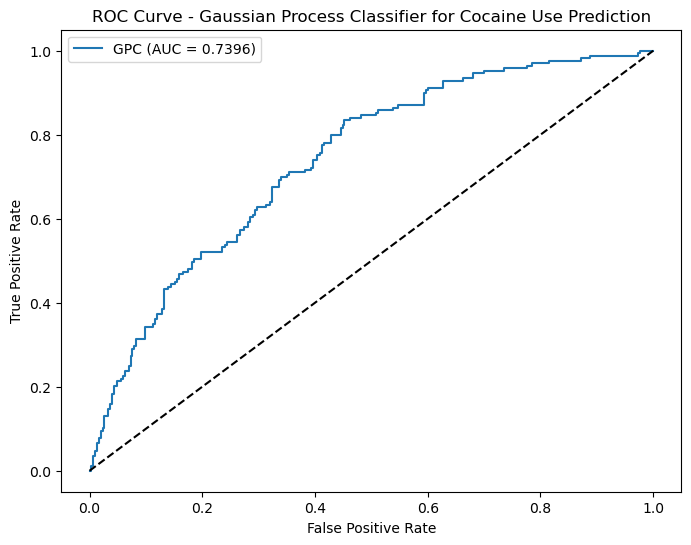


Model Performance Comparison:
                               Model  Accuracy       AUC
0        Gaussian Process Classifier  0.682203  0.739586
3           Logistic Regression (L2)  0.692797  0.726424
5       Bayesian Logistic Regression  0.690678  0.725858
4  Logistic Regression (Elastic Net)  0.680085  0.724549
1   Logistic Regression (no penalty)  0.690678  0.723846
2           Logistic Regression (L1)  0.686441  0.723182


In [38]:
# 3. Gaussian Process classification
# Set up the kernel for the Gaussian Process Classifier
kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1) # CV shows this to be the best one (not included here for brevity)

# Create and train the Gaussian Process classifier
gpc = GaussianProcessClassifier(kernel=kernel, random_state=42)
gpc.fit(X_train, y_train)

# Make predictions
y_pred_gpc = gpc.predict(X_test)
y_pred_gpc_proba = gpc.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_gpc = gpc.score(X_test, y_test)
auc_gpc = roc_auc_score(y_test, y_pred_gpc_proba)

# Print results
print("\nGaussian Process Classifier Results:")
print(f"Accuracy: {accuracy_gpc:.4f}")
print(f"ROC AUC: {auc_gpc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gpc))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_gpc))

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr_gpc, tpr_gpc, _ = roc_curve(y_test, y_pred_gpc_proba)
plt.plot(fpr_gpc, tpr_gpc, label=f'GPC (AUC = {auc_gpc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gaussian Process Classifier for Cocaine Use Prediction')
plt.legend()
plt.show()

# Compare with logistic regression models
all_results = {
    'Gaussian Process Classifier': {'accuracy': accuracy_gpc, 'auc': auc_gpc}
}
# Add logistic regression results
for name, result in results.items():
    all_results[name] = {'accuracy': result['accuracy'], 'auc': result['auc']}

# Create a comparison table
comparison_table = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Accuracy': [all_results[name]['accuracy'] for name in all_results],
    'AUC': [all_results[name]['auc'] for name in all_results]
})

# Sort by AUC score
comparison_table = comparison_table.sort_values('AUC', ascending=False)

print("\nModel Performance Comparison:")
print(comparison_table)

### 4. Summary plots

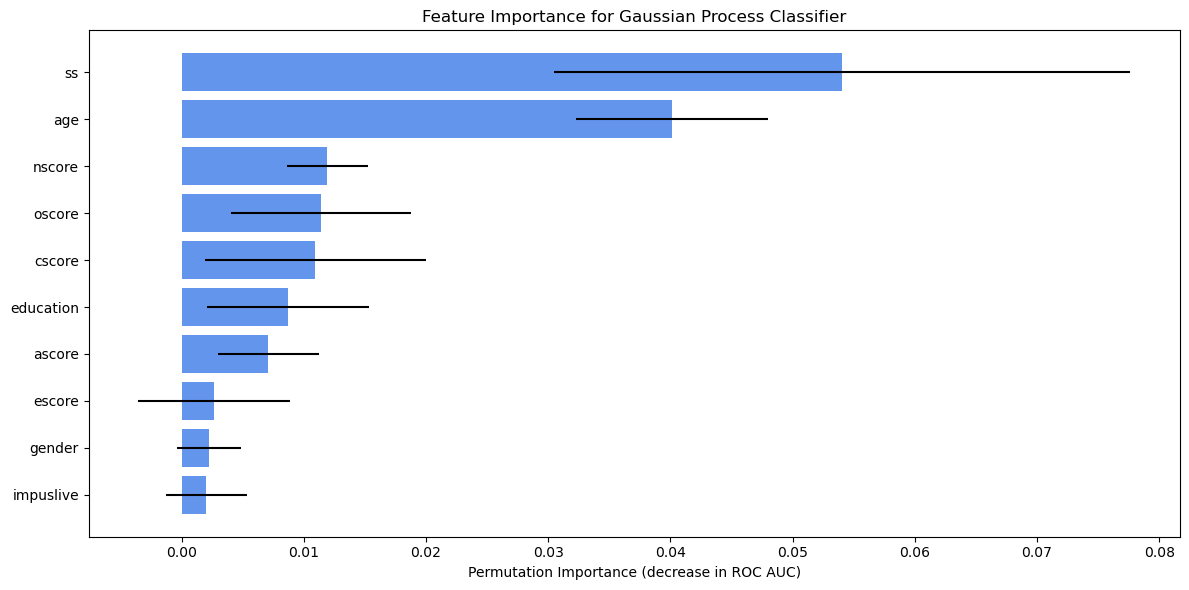

In [39]:
# Measure feature importance for Gaussian Process Classifier

# 1. Extract length scales from the RBF kernel if available
# Try to extract length scales from the kernel
has_length_scales = False
try:
    # Check if the kernel has length_scale attribute (RBF kernel)
    if hasattr(gpc.kernel_, 'k1') and hasattr(gpc.kernel_.k1, 'length_scale'):
        length_scales = gpc.kernel_.k1.length_scale
        if not np.isscalar(length_scales):
            # If we have one length scale per feature
            has_length_scales = True
            # Inverse of length scale can be used as importance (smaller length scale = more important)
            kernel_importance = 1 / length_scales
            # Normalize to 0-1 scale
            kernel_importance = kernel_importance / kernel_importance.sum()
            
            plt.figure(figsize=(12, 6))
            plt.bar(range(len(features)), kernel_importance)
            plt.xticks(range(len(features)), features, rotation=45)
            plt.xlabel('Features')
            plt.ylabel('Relative Importance (from kernel length scales)')
            plt.title('Feature Importance from GP Kernel Length Scales')
            plt.tight_layout()
            plt.show()
except:
    print("Could not extract length scales from the kernel.")

# 2. Calculate permutation feature importance
# This is a model-agnostic method to determine feature importance
result = permutation_importance(
    gpc, X_test, y_test, 
    n_repeats=10, 
    random_state=42,
    scoring='roc_auc'
)

# Extract and sort importance values
perm_importance = result.importances_mean
perm_importance_std = result.importances_std
sorted_idx = perm_importance.argsort()

# Plot permutation importance
plt.figure(figsize=(12, 6))
plt.barh(
    [features[i] for i in sorted_idx], 
    perm_importance[sorted_idx],
    xerr=perm_importance_std[sorted_idx],
    color='cornflowerblue'
)
plt.xlabel('Permutation Importance (decrease in ROC AUC)')
plt.title('Feature Importance for Gaussian Process Classifier')
plt.tight_layout()
plt.show()

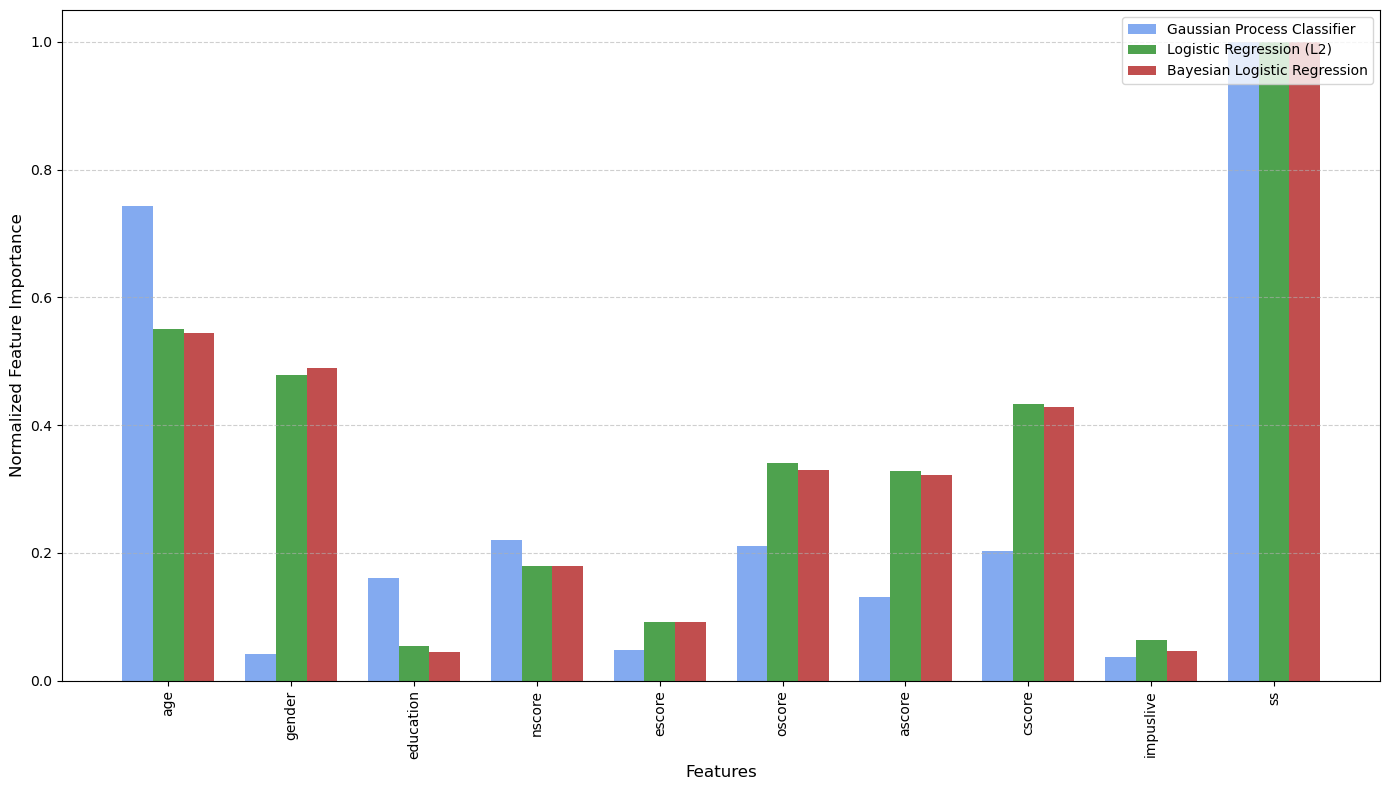

Top 3 important features - Gaussian Process Classifier:
1. ss: 1.0000
2. age: 0.7425
3. nscore: 0.2202

Top 3 important features - Logistic Regression (L2):
1. ss: 1.0000
2. age: 0.5513
3. gender: 0.4793

Top 3 important features - Bayesian Logistic Regression:
1. ss: 1.0000
2. age: 0.5448
3. gender: 0.4903

Features important across all three models: ss, age


In [40]:
# Plot feature importance comparison for the best classifiers

# Set up the figure
plt.figure(figsize=(14, 8))

# 1. Calculate feature importance for Gaussian Process Classifier via permutation importance
# We've already calculated this in the previous cell, so we'll reuse those values
result = permutation_importance(
    gpc, X_test, y_test, 
    n_repeats=10, 
    random_state=42,
    scoring='roc_auc'
)
gpc_importance = result.importances_mean
# Normalize to 0-1 scale for better comparison
gpc_importance = gpc_importance / gpc_importance.max()

# 2. Feature importance for Logistic Regression with L2 Penalty
lr_model = results['Logistic Regression (L2)']['model']
lr_importance = np.abs(lr_model.coef_[0])
# Normalize 
lr_importance = lr_importance / lr_importance.max()

# 3. Feature importance for Bayesian Logistic Regression
# Extract posterior mean of beta coefficients from trace
blr_importance = np.abs(trace.posterior.beta.mean(dim=["chain", "draw"]).values)
# Normalize
blr_importance = blr_importance / blr_importance.max()

# Set up bar positions
x_pos = np.arange(len(features))
width = 0.25

# Plot the bars for each model
plt.bar(x_pos - width, gpc_importance, width, 
        label='Gaussian Process Classifier', color='cornflowerblue', alpha=0.8)
plt.bar(x_pos, lr_importance, width, 
        label='Logistic Regression (L2)', color='forestgreen', alpha=0.8)
plt.bar(x_pos + width, blr_importance, width, 
        label='Bayesian Logistic Regression', color='firebrick', alpha=0.8)

# Add feature names and formatting
plt.xticks(x_pos, features, rotation=90)
plt.ylabel('Normalized Feature Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
# plt.title('Feature Importance Comparison Across Top Classification Models', fontsize=14)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Print the top 3 most important features for each model
print("Top 3 important features - Gaussian Process Classifier:")
gpc_top_idx = np.argsort(gpc_importance)[-3:]
for i, idx in enumerate(reversed(gpc_top_idx)):
    print(f"{i+1}. {features[idx]}: {gpc_importance[idx]:.4f}")

print("\nTop 3 important features - Logistic Regression (L2):")
lr_top_idx = np.argsort(lr_importance)[-3:]
for i, idx in enumerate(reversed(lr_top_idx)):
    print(f"{i+1}. {features[idx]}: {lr_importance[idx]:.4f}")

print("\nTop 3 important features - Bayesian Logistic Regression:")
blr_top_idx = np.argsort(blr_importance)[-3:]
for i, idx in enumerate(reversed(blr_top_idx)):
    print(f"{i+1}. {features[idx]}: {blr_importance[idx]:.4f}")

# Check for agreement in top features
common_features = set([features[i] for i in gpc_top_idx]) & set([features[i] for i in lr_top_idx]) & set([features[i] for i in blr_top_idx])
if common_features:
    print(f"\nFeatures important across all three models: {', '.join(common_features)}")

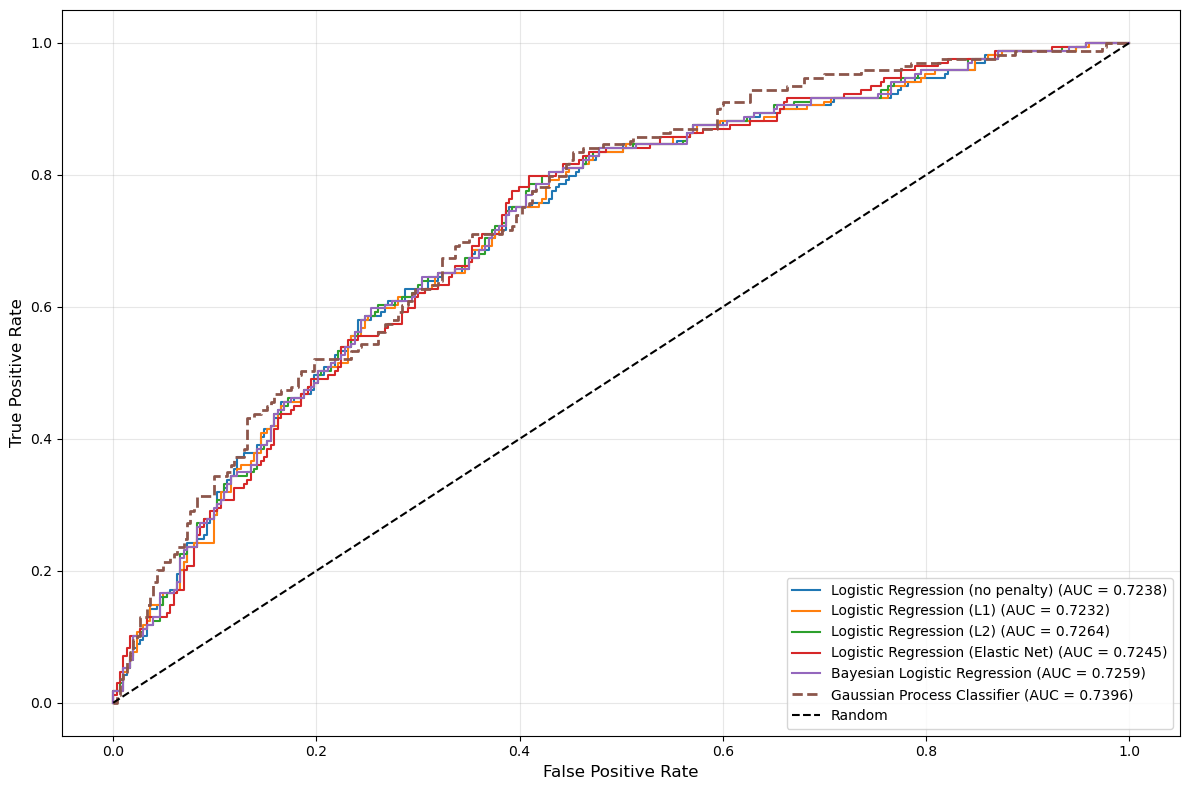

In [41]:
# Combine ROC curves for all classifiers into one graph
plt.figure(figsize=(12, 8))

# Add logistic regression models
for name, result in results.items():
    if name == 'Bayesian Logistic Regression':
        # For Bayesian logistic regression
        fpr_blr, tpr_blr, _ = roc_curve(y_test, y_pred_proba_blr)
        plt.plot(fpr_blr, tpr_blr, label=f"{name} (AUC = {auc_blr:.4f})")
    elif 'Logistic Regression' in name:
        # Get the model
        model = result['model']
        # Calculate ROC curve
        y_pred_proba_lr = model.predict_proba(X_test)[:, 1]
        fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
        plt.plot(fpr_lr, tpr_lr, label=f"{name} (AUC = {result['auc']:.4f})")

# Add Gaussian Process Classifier
fpr_gpc, tpr_gpc, _ = roc_curve(y_test, y_pred_gpc_proba)
plt.plot(fpr_gpc, tpr_gpc, label=f'Gaussian Process Classifier (AUC = {auc_gpc:.4f})', linestyle='--', linewidth=2)

# Add diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Customize the plot
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
# plt.title('ROC Curves for All Classification Models', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)

# Add a tight layout
plt.tight_layout()

# Show the plot
plt.show()

## II. Regression

### 1. Linear regression


Tuning Linear Regression (no penalty)...
Mean Squared Error: 2.0291
Root Mean Squared Error: 1.4245
R² Score: 0.1704
Mean Absolute Error: 1.1666

Tuning Linear Regression (L1)...
Best parameters: {'alpha': np.float64(0.004641588833612782)}
Mean Squared Error: 2.0323
Root Mean Squared Error: 1.4256
R² Score: 0.1691
Mean Absolute Error: 1.1688

Tuning Linear Regression (L2)...
Best parameters: {'alpha': np.float64(10.0)}
Mean Squared Error: 2.0284
Root Mean Squared Error: 1.4242
R² Score: 0.1706
Mean Absolute Error: 1.1669

Tuning Linear Regression (Elastic Net)...
Best parameters: {'alpha': np.float64(0.01), 'l1_ratio': 0.3}
Mean Squared Error: 2.0305
Root Mean Squared Error: 1.4249
R² Score: 0.1698
Mean Absolute Error: 1.1683


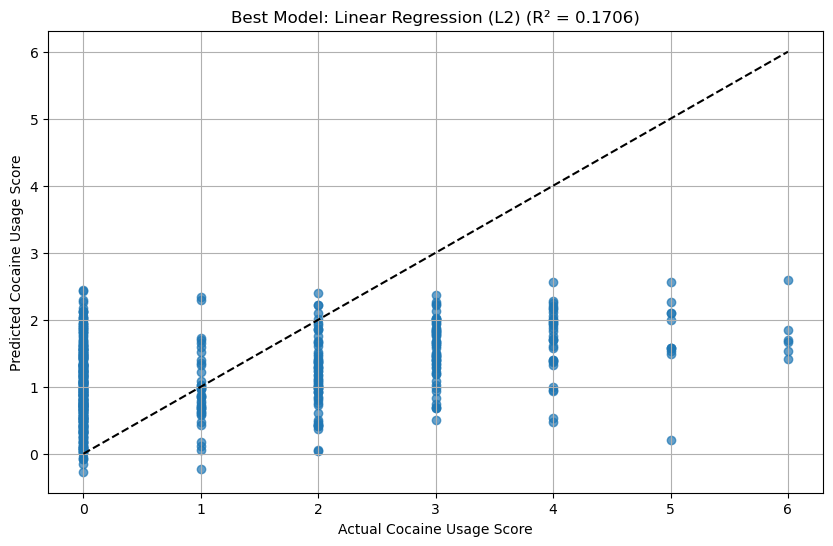

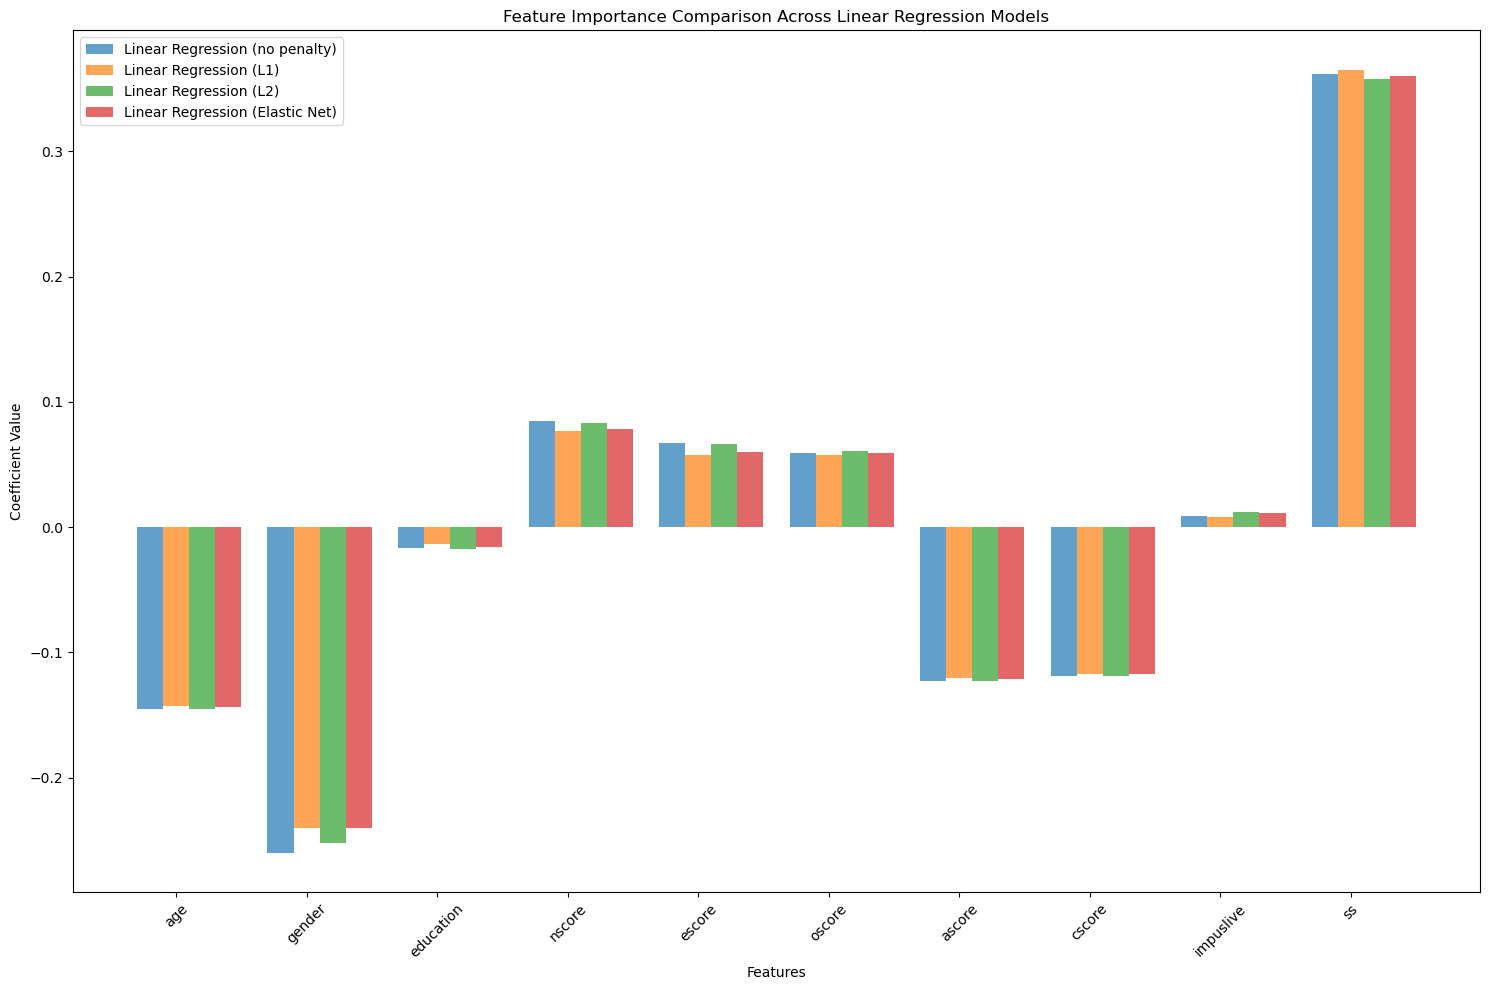


Model Performance Comparison:
                             Model       MSE      RMSE        R²       MAE
2           Linear Regression (L2)  2.028411  1.424223  0.170646  1.166893
0   Linear Regression (no penalty)  2.029089  1.424461  0.170369  1.166563
3  Linear Regression (Elastic Net)  2.030455  1.424940  0.169810  1.168350
1           Linear Regression (L1)  2.032262  1.425574  0.169071  1.168845


In [42]:
# 1. Linear regression (with different penalty terms)

# Create a dictionary to store results
results_reg = {}

# Define the models with different regularization
linear_reg_models = {
    'Linear Regression (no penalty)': LinearRegression(),
    'Linear Regression (L1)': Lasso(max_iter=10000, random_state=42),
    'Linear Regression (L2)': Ridge(random_state=42),
    'Linear Regression (Elastic Net)': ElasticNet(max_iter=10000, random_state=42)
}

# Parameters for grid search
param_grids = {
    'Linear Regression (no penalty)': {},
    'Linear Regression (L1)': {'alpha': np.logspace(-4, 1, 10)},
    'Linear Regression (L2)': {'alpha': np.logspace(-4, 1, 10)},
    'Linear Regression (Elastic Net)': {
        'alpha': np.logspace(-4, 1, 6),
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
}

# Fit models and evaluate
for name, model in linear_reg_models.items():
    print(f"\nTuning {name}...")
    
    # Grid search for hyperparameter tuning
    if param_grids[name]:  # If there are hyperparameters to tune
        grid_search = GridSearchCV(
            model, 
            param_grids[name], 
            cv=5, 
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        grid_search.fit(X_train_reg, y_train_reg)
        
        # Get the best model
        best_model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
    else:
        # No hyperparameters to tune
        best_model = model
        best_model.fit(X_train_reg, y_train_reg)
    
    # Make predictions
    y_pred = best_model.predict(X_test_reg)
    
    # Calculate metrics
    mse = mean_squared_error(y_test_reg, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_reg, y_pred)
    mae = mean_absolute_error(y_test_reg, y_pred)
    
    # Store results
    results_reg[name] = {
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'mae': mae,
        'model': best_model
    }
    
    # Print metrics
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")

# Plot actual vs predicted values for the best model based on R²
best_model_name = max(results_reg, key=lambda x: results_reg[x]['r2'])
best_model = results_reg[best_model_name]['model']
best_r2 = results_reg[best_model_name]['r2']

plt.figure(figsize=(10, 6))
y_pred_best = best_model.predict(X_test_reg)
plt.scatter(y_test_reg, y_pred_best, alpha=0.7)
plt.plot([0, 6], [0, 6], 'k--')
plt.xlabel('Actual Cocaine Usage Score')
plt.ylabel('Predicted Cocaine Usage Score')
plt.title(f'Best Model: {best_model_name} (R² = {best_r2:.4f})')
plt.grid(True)
plt.show()

# Compare coefficients across models
plt.figure(figsize=(15, 10))
bar_width = 0.2
index = np.arange(len(features))

for i, (name, result) in enumerate(results_reg.items()):
    if hasattr(result['model'], 'coef_'):
        coeffs = result['model'].coef_
        plt.bar(index + i*bar_width, coeffs, bar_width, label=name, alpha=0.7)

plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Importance Comparison Across Linear Regression Models')
plt.xticks(index + bar_width, features, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Create a results comparison table
results_table = pd.DataFrame({
    'Model': list(results_reg.keys()),
    'MSE': [results_reg[name]['mse'] for name in results_reg],
    'RMSE': [results_reg[name]['rmse'] for name in results_reg],
    'R²': [results_reg[name]['r2'] for name in results_reg],
    'MAE': [results_reg[name]['mae'] for name in results_reg]
})

# Sort by R² score
results_table = results_table.sort_values('R²', ascending=False)
print("\nModel Performance Comparison:")
print(results_table)

### 2. Bayesian linear regression

Initializing NUTS using jitter+adapt_diag...



Evaluating prior configuration 1/7: 0.1


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 1: MSE = 1.9204, R² = 0.1166


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 2: MSE = 1.8635, R² = 0.1561


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


  Fold 3: MSE = 1.9530, R² = 0.1712


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 4: MSE = 1.8237, R² = 0.1671


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 5: MSE = 1.9126, R² = 0.1445
Configuration 1 average: MSE = 1.8946, R² = 0.1511

Evaluating prior configuration 2/7: 0.25


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 1: MSE = 1.9357, R² = 0.1096


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 2: MSE = 1.8550, R² = 0.1600


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 3: MSE = 1.9468, R² = 0.1738


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 4: MSE = 1.8267, R² = 0.1658


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 5: MSE = 1.9038, R² = 0.1484
Configuration 2 average: MSE = 1.8936, R² = 0.1515

Evaluating prior configuration 3/7: 0.5


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 1: MSE = 1.9392, R² = 0.1080


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 2: MSE = 1.8537, R² = 0.1605


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 3: MSE = 1.9466, R² = 0.1739


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 4: MSE = 1.8290, R² = 0.1647


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 5: MSE = 1.9030, R² = 0.1488
Configuration 3 average: MSE = 1.8943, R² = 0.1512

Evaluating prior configuration 4/7: 0.75


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 1: MSE = 1.9408, R² = 0.1072


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 2: MSE = 1.8534, R² = 0.1607


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 3: MSE = 1.9469, R² = 0.1737


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 4: MSE = 1.8293, R² = 0.1646


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 5: MSE = 1.9032, R² = 0.1487
Configuration 4 average: MSE = 1.8947, R² = 0.1510

Evaluating prior configuration 5/7: 1


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 1: MSE = 1.9402, R² = 0.1075


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 2: MSE = 1.8535, R² = 0.1606


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


  Fold 3: MSE = 1.9469, R² = 0.1737


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 4: MSE = 1.8296, R² = 0.1644


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 5: MSE = 1.9028, R² = 0.1489
Configuration 5 average: MSE = 1.8946, R² = 0.1510

Evaluating prior configuration 6/7: 3


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 1: MSE = 1.9412, R² = 0.1071


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 2: MSE = 1.8535, R² = 0.1606


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 3: MSE = 1.9470, R² = 0.1737


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 4: MSE = 1.8297, R² = 0.1644


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 5: MSE = 1.9029, R² = 0.1488
Configuration 6 average: MSE = 1.8949, R² = 0.1509

Evaluating prior configuration 7/7: 5


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 1: MSE = 1.9420, R² = 0.1067


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 2: MSE = 1.8534, R² = 0.1607


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 3: MSE = 1.9475, R² = 0.1735


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 4: MSE = 1.8297, R² = 0.1644


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  Fold 5: MSE = 1.9022, R² = 0.1491
Configuration 7 average: MSE = 1.8950, R² = 0.1509

Best prior configuration: 0.25
Best average R²: 0.1515
Best average MSE: 1.8936

Training final model with best configuration...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.



Bayesian Linear Regression - Parameter Summary (truncated):
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    1.163  0.036   1.098    1.231      0.000    0.001    7971.0   
beta[0] -0.146  0.044  -0.229   -0.067      0.000    0.001    7971.0   
beta[1] -0.238  0.080  -0.391   -0.093      0.001    0.001    7104.0   
beta[2] -0.019  0.039  -0.094    0.051      0.000    0.001    6927.0   
beta[3]  0.080  0.044  -0.002    0.160      0.001    0.001    6540.0   

         ess_tail  r_hat  
alpha      3097.0    1.0  
beta[0]    3142.0    1.0  
beta[1]    3210.0    1.0  
beta[2]    3514.0    1.0  
beta[3]    3457.0    1.0  

Bayesian Linear Regression Results:
Mean Squared Error: 2.0272
Root Mean Squared Error: 1.4238
R² Score: 0.1711
Mean Absolute Error: 1.1676


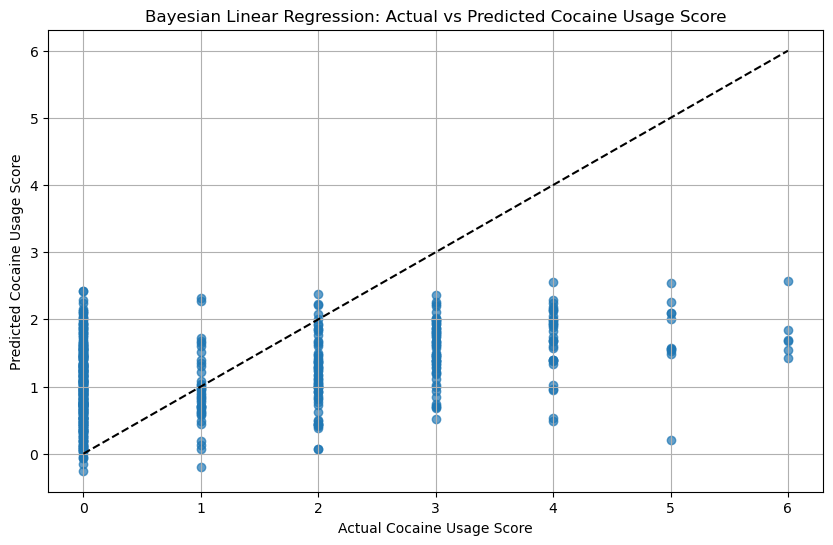

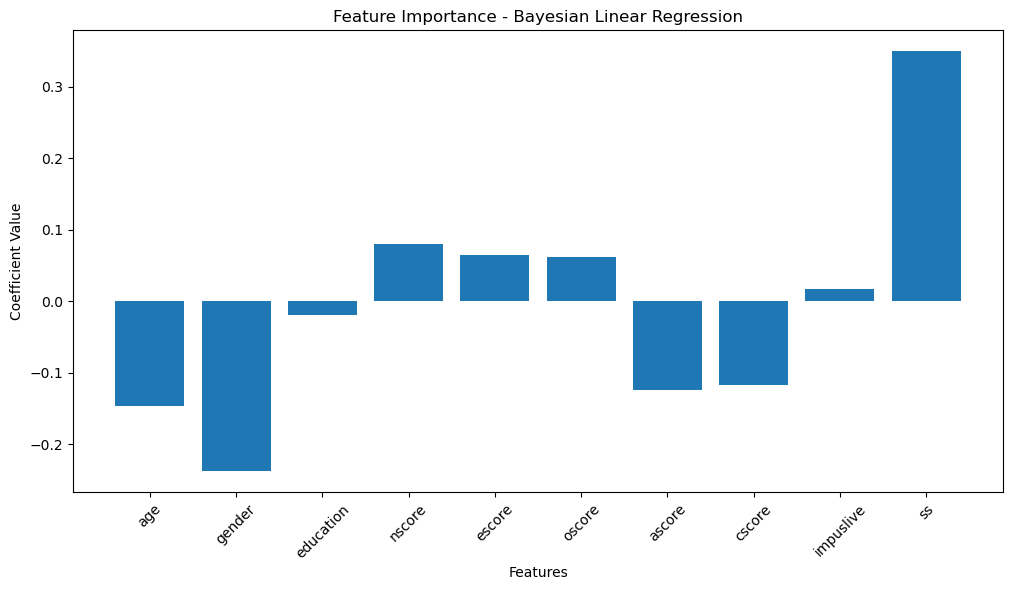


Model Performance Comparison:
                             Model       MSE      RMSE        R²       MAE
4       Bayesian Linear Regression  2.027213  1.423802  0.171136  1.167571
2           Linear Regression (L2)  2.028411  1.424223  0.170646  1.166893
0   Linear Regression (no penalty)  2.029089  1.424461  0.170369  1.166563
3  Linear Regression (Elastic Net)  2.030455  1.424940  0.169810  1.168350
1           Linear Regression (L1)  2.032262  1.425574  0.169071  1.168845


In [43]:
# 2. Bayesian linear regression
# Perform cross-validation to evaluate different prior settings

# Define different prior configurations to test
prior_configs = [0.1, 0.25, 0.5, 0.75, 1, 3, 5]

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

# Perform cross-validation for each prior configuration
for config_idx, config in enumerate(prior_configs):
    print(f"\nEvaluating prior configuration {config_idx+1}/{len(prior_configs)}: {config}")
    fold_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train_reg)):
        # Split data for this fold
        X_cv_train, X_cv_val = X_train_reg[train_idx], X_train_reg[val_idx]
        y_cv_train, y_cv_val = y_train_reg[train_idx], y_train_reg[val_idx]
        
        # Create and train model with current prior configuration
        with pm.Model() as cv_model:
            # Priors with current configuration
            alpha = pm.Normal("alpha", mu=0, sigma=5)
            beta = pm.Normal("beta", mu=0, sigma=config, shape=X_cv_train.shape[1])
            sigma = pm.HalfNormal("sigma", sigma=10)
            
            # Expected value of outcome
            mu = alpha + pm.math.dot(X_cv_train, beta)
            
            # Likelihood
            y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_cv_train)
            
            # Use a smaller number of samples for speed in CV
            trace = pm.sample(500, tune=500, random_seed=42, return_inferencedata=True, progressbar=False)
        
        # Make predictions on validation set
        alpha_samples = trace.posterior.alpha.values.flatten()
        beta_samples = trace.posterior.beta.values.reshape(-1, X_cv_val.shape[1])
        y_pred = alpha_samples[:, None] + np.dot(beta_samples, X_cv_val.T)
        y_pred_mean = y_pred.mean(axis=0)
        
        # Calculate validation metrics
        mse = mean_squared_error(y_cv_val, y_pred_mean)
        r2 = r2_score(y_cv_val, y_pred_mean)
        fold_scores.append({'mse': mse, 'r2': r2})
        
        print(f"  Fold {fold_idx+1}: MSE = {mse:.4f}, R² = {r2:.4f}")
    
    # Calculate average scores across folds
    avg_mse = np.mean([score['mse'] for score in fold_scores])
    avg_r2 = np.mean([score['r2'] for score in fold_scores])
    cv_results.append({
        'config': config,
        'avg_mse': avg_mse,
        'avg_r2': avg_r2
    })
    print(f"Configuration {config_idx+1} average: MSE = {avg_mse:.4f}, R² = {avg_r2:.4f}")

# Find the best configuration
best_config_idx = np.argmax([result['avg_r2'] for result in cv_results])
best_config = prior_configs[best_config_idx]
print(f"\nBest prior configuration: {best_config}")
print(f"Best average R²: {cv_results[best_config_idx]['avg_r2']:.4f}")
print(f"Best average MSE: {cv_results[best_config_idx]['avg_mse']:.4f}")

# Use the best configuration for the final model
print("\nTraining final model with best configuration...")
# Set up the Bayesian linear regression model
with pm.Model() as blr_reg_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=3)
    beta = pm.Normal("beta", mu=0, sigma=best_config, shape=X_train_reg.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Expected value of outcome
    mu = alpha + pm.math.dot(X_train_reg, beta)
    
    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train_reg)
    
    # Sample from the posterior
    trace_reg = pm.sample(1000, tune=1000, random_seed=42, return_inferencedata=True)
    
    # Summary of the posterior
    summary_reg = az.summary(trace_reg, var_names=["alpha", "beta", "sigma"])
    print("\nBayesian Linear Regression - Parameter Summary (truncated):")
    print(summary_reg.head())

# Create function to predict from the Bayesian linear regression model
def predict_blr(X, trace):
    # Extract samples
    alpha_samples = trace.posterior.alpha.values.flatten()
    beta_samples = trace.posterior.beta.values.reshape(-1, X.shape[1])
    
    # Calculate predictions
    y_pred = alpha_samples[:, None] + np.dot(beta_samples, X.T)
    return y_pred.mean(axis=0)

# Make predictions
y_pred_blr_reg = predict_blr(X_test_reg, trace_reg)

# Evaluate the model
mse_blr = mean_squared_error(y_test_reg, y_pred_blr_reg)
rmse_blr = np.sqrt(mse_blr)
r2_blr = r2_score(y_test_reg, y_pred_blr_reg)
mae_blr = mean_absolute_error(y_test_reg, y_pred_blr_reg)

print("\nBayesian Linear Regression Results:")
print(f"Mean Squared Error: {mse_blr:.4f}")
print(f"Root Mean Squared Error: {rmse_blr:.4f}")
print(f"R² Score: {r2_blr:.4f}")
print(f"Mean Absolute Error: {mae_blr:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_blr_reg, alpha=0.7)
plt.plot([0, 6], [0, 6], 'k--')
plt.xlabel('Actual Cocaine Usage Score')
plt.ylabel('Predicted Cocaine Usage Score')
plt.title('Bayesian Linear Regression: Actual vs Predicted Cocaine Usage Score')
plt.grid(True)
plt.show()

# Plot feature importance (coefficients)
plt.figure(figsize=(12, 6))
coef_means_blr = trace_reg.posterior.beta.mean(dim=["chain", "draw"]).values
plt.bar(range(len(features)), coef_means_blr)
plt.xticks(range(len(features)), features, rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Importance - Bayesian Linear Regression')
plt.show()

# Add to the results dictionary
results_reg['Bayesian Linear Regression'] = {'mse': mse_blr, 'rmse': rmse_blr, 'r2': r2_blr, 'mae': mae_blr}

# Create an updated comparison table
comparison_table_reg_updated = pd.DataFrame({
    'Model': list(results_reg.keys()),
    'MSE': [results_reg[name]['mse'] for name in results_reg],
    'RMSE': [results_reg[name]['rmse'] for name in results_reg],
    'R²': [results_reg[name]['r2'] for name in results_reg],
    'MAE': [results_reg[name]['mae'] for name in results_reg]
})

# Sort by R² score in descending order
comparison_table_reg_updated = comparison_table_reg_updated.sort_values('R²', ascending=False)

# Display the results table
print("\nModel Performance Comparison:")
print(comparison_table_reg_updated)

### 3. Gaussian Process regression


Gaussian Process Regressor Results:
Mean Squared Error: 1.9921
Root Mean Squared Error: 1.4114
R² Score: 0.1855
Mean Absolute Error: 1.1478


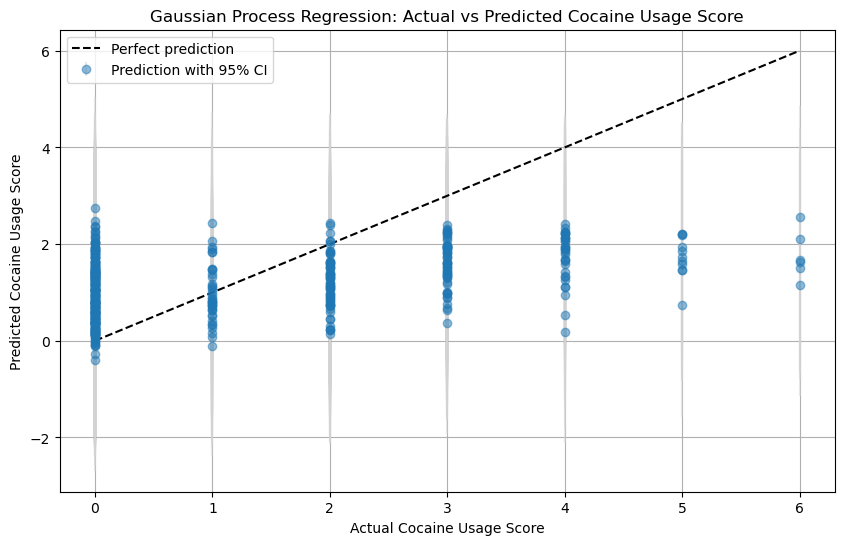


Regression Model Performance Comparison:
                             Model       MSE      RMSE        R²       MAE
0       Gaussian Process Regressor  1.992124  1.411426  0.185483  1.147809
5       Bayesian Linear Regression  2.027213  1.423802  0.171136  1.167571
3           Linear Regression (L2)  2.028411  1.424223  0.170646  1.166893
1   Linear Regression (no penalty)  2.029089  1.424461  0.170369  1.166563
4  Linear Regression (Elastic Net)  2.030455  1.424940  0.169810  1.168350
2           Linear Regression (L1)  2.032262  1.425574  0.169071  1.168845

Optimized kernel parameters:
1.09**2 * RBF(length_scale=4.44) + WhiteKernel(noise_level=1.81)


In [44]:
# 3. Gaussian Process regression
# Set up the kernel for Gaussian Process Regression
# Using a combination of RBF kernel with a constant kernel and white noise (again, found by CV, omitted here for brevity)
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(0.1)

# Create and train the Gaussian Process regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr.fit(X_train_reg, y_train_reg)

# Make predictions
y_pred_gpr = gpr.predict(X_test_reg)
y_pred_gpr_std = np.sqrt(gpr.predict(X_test_reg, return_std=True)[1])

# Evaluate the model
mse_gpr = mean_squared_error(y_test_reg, y_pred_gpr)
rmse_gpr = np.sqrt(mse_gpr)
r2_gpr = r2_score(y_test_reg, y_pred_gpr)
mae_gpr = mean_absolute_error(y_test_reg, y_pred_gpr)

# Print results
print("\nGaussian Process Regressor Results:")
print(f"Mean Squared Error: {mse_gpr:.4f}")
print(f"Root Mean Squared Error: {rmse_gpr:.4f}")
print(f"R² Score: {r2_gpr:.4f}")
print(f"Mean Absolute Error: {mae_gpr:.4f}")

# Plot actual vs predicted values with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(y_test_reg, y_pred_gpr, yerr=1.96*y_pred_gpr_std, fmt='o', alpha=0.5, ecolor='lightgray', label='Prediction with 95% CI')
plt.plot([0, 6], [0, 6], 'k--', label='Perfect prediction')
plt.xlabel('Actual Cocaine Usage Score')
plt.ylabel('Predicted Cocaine Usage Score')
plt.title('Gaussian Process Regression: Actual vs Predicted Cocaine Usage Score')
plt.legend()
plt.grid(True)
plt.show()

# Compare with other regression models
all_results_reg = {
    'Gaussian Process Regressor': {'mse': mse_gpr, 'rmse': rmse_gpr, 'r2': r2_gpr, 'mae': mae_gpr}
}
# Add existing linear regression results
for name, result in results_reg.items():
    all_results_reg[name] = {'mse': result['mse'], 'rmse': result['rmse'], 'r2': result['r2'], 'mae': result['mae']}

# Create a comparison table
comparison_table_reg = pd.DataFrame({
    'Model': list(all_results_reg.keys()),
    'MSE': [all_results_reg[name]['mse'] for name in all_results_reg],
    'RMSE': [all_results_reg[name]['rmse'] for name in all_results_reg],
    'R²': [all_results_reg[name]['r2'] for name in all_results_reg],
    'MAE': [all_results_reg[name]['mae'] for name in all_results_reg]
})

# Sort by R² score
comparison_table_reg = comparison_table_reg.sort_values('R²', ascending=False)

print("\nRegression Model Performance Comparison:")
print(comparison_table_reg)

# Examine the optimized kernel parameters
print("\nOptimized kernel parameters:")
print(gpr.kernel_)



### 4. Summary plots

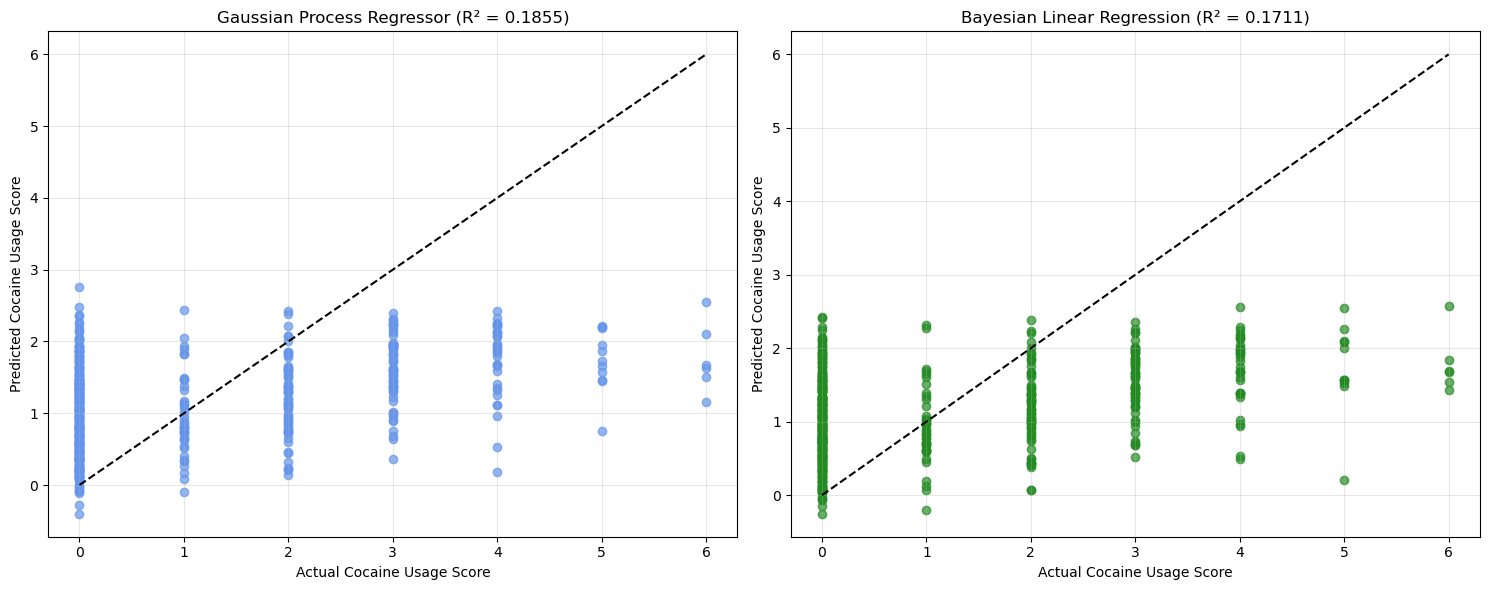

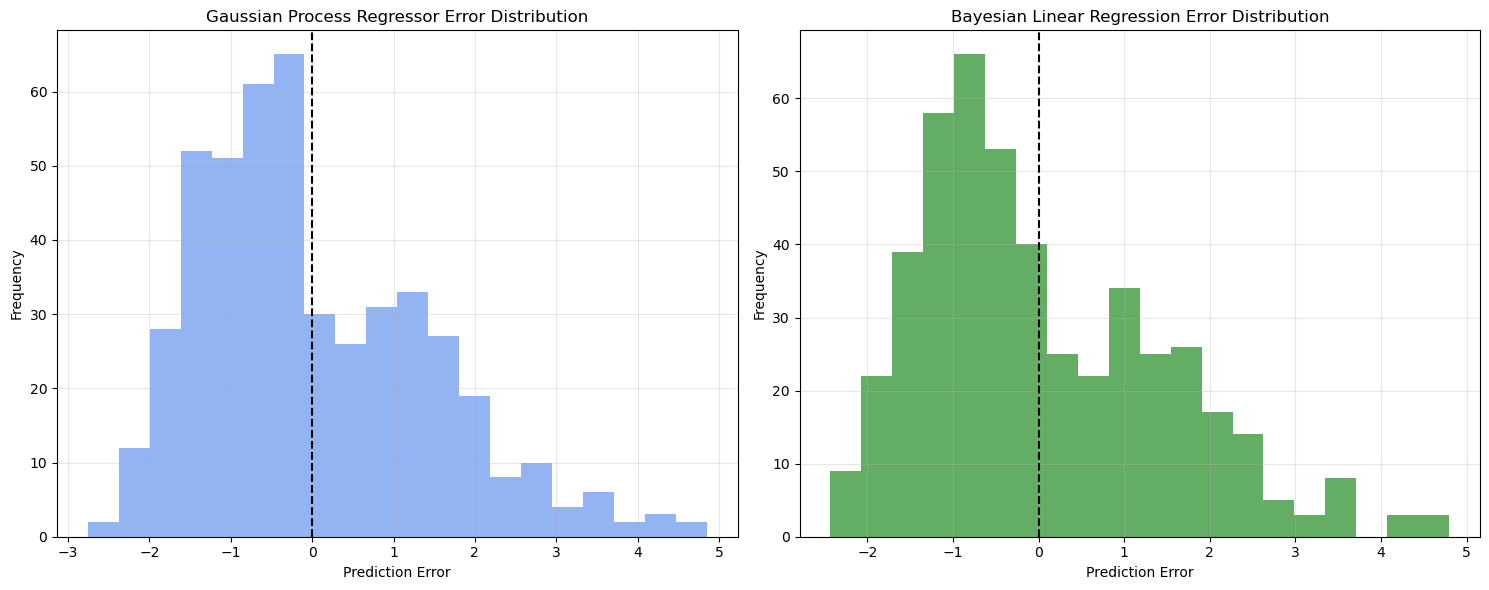

Gaussian Process Regressor Error Statistics:
Mean Error: 0.0155
Std Dev: 1.4113
Min: -2.7539, Max: 4.8462

Bayesian Linear Regression Error Statistics:
Mean Error: 0.0185
Std Dev: 1.4237
Min: -2.4299, Max: 4.7938


In [45]:
# Compare actual vs predicted values for Gaussian Process Regression and Bayesian Linear Regression
plt.figure(figsize=(15, 6))

# For Bayesian Linear Regression, use the predictions we already calculated earlier
y_pred_blr = y_pred_blr_reg  

# Plot for Gaussian Process Regressor
plt.subplot(1, 2, 1)
plt.scatter(y_test_reg, y_pred_gpr, alpha=0.7, color='cornflowerblue')
plt.plot([0, 6], [0, 6], 'k--')
plt.xlabel('Actual Cocaine Usage Score')
plt.ylabel('Predicted Cocaine Usage Score')
plt.title(f'Gaussian Process Regressor (R² = {r2_gpr:.4f})')
plt.grid(True, alpha=0.3)

# Plot for Bayesian Linear Regression
plt.subplot(1, 2, 2)
plt.scatter(y_test_reg, y_pred_blr, alpha=0.7, color='forestgreen')
plt.plot([0, 6], [0, 6], 'k--')
plt.xlabel('Actual Cocaine Usage Score')
plt.ylabel('Predicted Cocaine Usage Score')
plt.title(f'Bayesian Linear Regression (R² = {results_reg["Bayesian Linear Regression"]["r2"]:.4f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate prediction errors and visualize their distribution
plt.figure(figsize=(15, 6))

# Errors for Gaussian Process Regressor
errors_gpr = y_test_reg - y_pred_gpr
plt.subplot(1, 2, 1)
plt.hist(errors_gpr, bins=20, alpha=0.7, color='cornflowerblue')
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Gaussian Process Regressor Error Distribution')
plt.grid(True, alpha=0.3)

# Errors for Bayesian Linear Regression
errors_blr = y_test_reg - y_pred_blr
plt.subplot(1, 2, 2)
plt.hist(errors_blr, bins=20, alpha=0.7, color='forestgreen')
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Bayesian Linear Regression Error Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics of the errors
print("Gaussian Process Regressor Error Statistics:")
print(f"Mean Error: {np.mean(errors_gpr):.4f}")
print(f"Std Dev: {np.std(errors_gpr):.4f}")
print(f"Min: {np.min(errors_gpr):.4f}, Max: {np.max(errors_gpr):.4f}")
print()
print("Bayesian Linear Regression Error Statistics:")
print(f"Mean Error: {np.mean(errors_blr):.4f}")
print(f"Std Dev: {np.std(errors_blr):.4f}")
print(f"Min: {np.min(errors_blr):.4f}, Max: {np.max(errors_blr):.4f}")

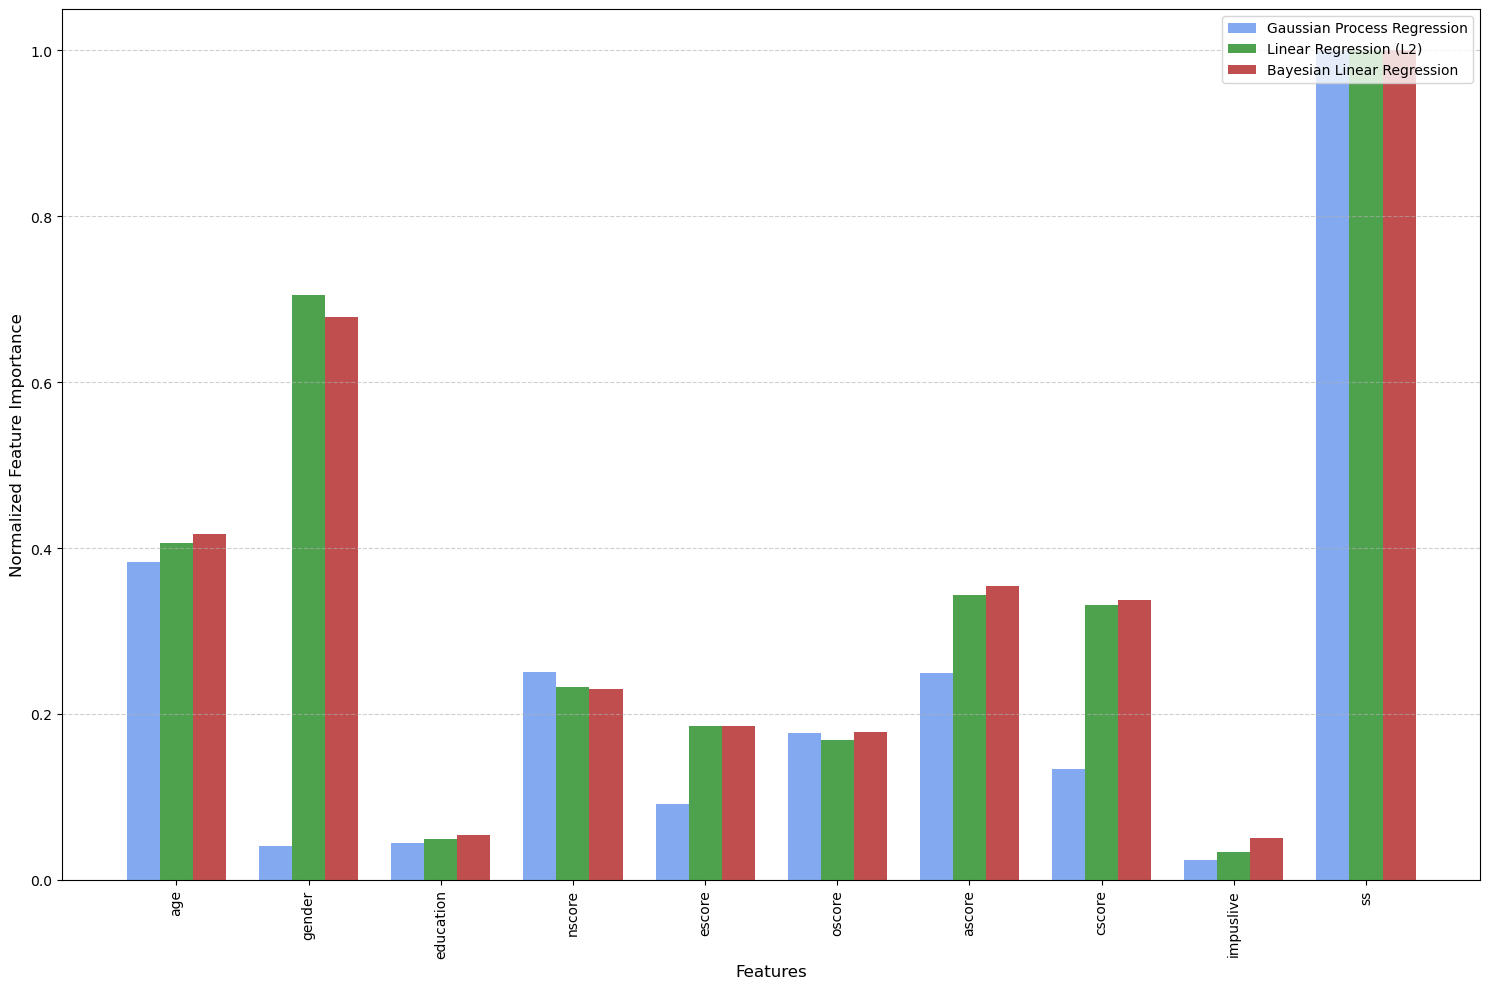

Top 3 important features - Gaussian Process Regression:
1. ss: 1.0000
2. age: 0.3828
3. nscore: 0.2507

Top 3 important features - Linear Regression (L2):
1. ss: 1.0000
2. gender: 0.7045
3. age: 0.4062

Top 3 important features - Bayesian Linear Regression:
1. ss: 1.0000
2. gender: 0.6791
3. age: 0.4171


In [46]:
# Feature importance plot

# Create a comparison plot of feature importance for the three best regression models
plt.figure(figsize=(15, 10))

# 1. Extract feature importance for Gaussian Process Regression
# Using permutation importance
result_gpr = permutation_importance(
    gpr, X_test_reg, y_test_reg, 
    n_repeats=10, 
    random_state=42,
    scoring='r2'
)
perm_importance_gpr = result_gpr.importances_mean
gpr_importance = perm_importance_gpr
# Normalize to 0-1 scale for better comparison
gpr_importance = gpr_importance / gpr_importance.max()

# 2. Extract feature importance for Linear Regression with L2 Penalty
lr_l2_model = results_reg['Linear Regression (L2)']['model']
lr_importance = np.abs(lr_l2_model.coef_)
# Normalize
lr_importance = lr_importance / lr_importance.max()

# 3. Extract feature importance for Bayesian Linear Regression
blr_importance = np.abs(coef_means_blr)
# Normalize
blr_importance = blr_importance / blr_importance.max()

# Set up the bar chart with vertical bars
x_pos = np.arange(len(features))
width = 0.25

# Plot bars for each model
plt.bar(x_pos - width, gpr_importance, width, 
         label='Gaussian Process Regression', color='cornflowerblue', alpha=0.8)
plt.bar(x_pos, lr_importance, width, 
         label='Linear Regression (L2)', color='forestgreen', alpha=0.8)
plt.bar(x_pos + width, blr_importance, width, 
         label='Bayesian Linear Regression', color='firebrick', alpha=0.8)

# Add feature names, title, and labels
plt.xticks(x_pos, features, rotation=90)
plt.ylabel('Normalized Feature Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
# plt.title('Feature Importance Comparison Across Top Regression Models', fontsize=16)
plt.legend(loc='upper right')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add a tight layout
plt.tight_layout()

# Show the plot
plt.show()

# Print the top 3 most important features for each model
print("Top 3 important features - Gaussian Process Regression:")
gpr_top_idx = np.argsort(gpr_importance)[-3:]
for i, idx in enumerate(reversed(gpr_top_idx)):
    print(f"{i+1}. {features[idx]}: {gpr_importance[idx]:.4f}")

print("\nTop 3 important features - Linear Regression (L2):")
lr_top_idx = np.argsort(lr_importance)[-3:]
for i, idx in enumerate(reversed(lr_top_idx)):
    print(f"{i+1}. {features[idx]}: {lr_importance[idx]:.4f}")

print("\nTop 3 important features - Bayesian Linear Regression:")
blr_top_idx = np.argsort(blr_importance)[-3:]
for i, idx in enumerate(reversed(blr_top_idx)):
    print(f"{i+1}. {features[idx]}: {blr_importance[idx]:.4f}")